# Assignment 1: Professionalism and Reproducibility

In [10]:
import json, time, urllib.parse

import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Introduction

In the popular and well-known public information website, Wikipedia, several articles exist that describe or tangentially discuss different rare diseases. For each of these pages, as with all its others, the site maintains a record of the number of times that page was viewed and the platform that it was viewed from. The purpose of this notebook is to provide a brief and reproducible analysis of some of the pageview trends for Wikipedia's articles on rare diseases..

As part of this analysis, the most and least viewed pages, the peak page views, and the months of fewest data will be investigated using data pulled from the wikimedia analytics API.

In [11]:
# Reading in CSV file of rare disease wikipedia pages
wikipedia_rare_diseases_df = pd.read_csv("rare-disease_cleaned.AUG.2024.csv")

The data used for this rare disease pageview analysis will be obtained from the Wikimedia Analytics API in monthly increments from July of 2015 to September of 2024. To allow for comparisons between user bases, the pageviews for desktop users will be obtained and stored separately from the pageviews for mobile users (on both the web and the app). All pageview information will be taken strictly with regard to Wikipedia users, in order to remain with the scope of this analysis.

In order to ensure that only pages associated with rare diseases are included in this anlysis, a [csv file](rare-disease_cleaned.AUG.2024.csv) containing the titles of 1773 Wikipedia pages that make a reference to a rare disease will be used. API calls will only request monthly pageview data from these specific pages. 

### Data Acquisition

The following two code blocks are largely taken from David McDonald's [sample wikimedia notebook](wp_article_views_example.ipynb) in order to make requests of the API.

In [120]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 1ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<brunob42@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = wikipedia_rare_diseases_df.disease

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",
    "agent":       "user",
    "article":     "",
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2024090100"
}
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",
    "agent":       "user",
    "article":     "",
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2024090100"
}
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",
    "agent":       "user",
    "article":     "",
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2024090100"
}
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_CUMULATIVE = {
    "project":     "en.wikipedia.org",
    "access":      "all-access",
    "agent":       "user",
    "article":     "",
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2024090100"
}

In [33]:
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In the following three cells, the pageview data on rare disease pages are obtained for desktop users, mobile users, and total users, in that order.

Once collected, the three datasets will be stored as JSON files for accessibility and future use.
* Desktop data will be stored in `rare-disease_monthly_desktop_start201507-end202409.json`
* Mobile data will be stored in `rare-disease_monthly_mobile_start201507-end202409.json`
* Cumulative data will be stored in `rare-disease_monthly_cumulative_start201507-end202409.json`

In [ ]:
# Obtaining pageviews access data for desktop users
pageviews_desktop_list = []
for article_num, article_title in enumerate(wikipedia_rare_diseases_df.disease):
    print("Getting pageview data for: ", article_title, str(article_num) + " / " + str(len(wikipedia_rare_diseases_df.disease)), "                ", end="\r")
    views = request_pageviews_per_article(article_title)
    missing_entry = [{
    "project": "en.wikipedia",
    "article": article_title,
    "granularity": "monthly",
    "timestamp": "N/A",
    "access": "desktop",
    "agent": "user",
    "views": "N/A"
    }]
    pageviews_desktop_list = pageviews_desktop_list + views.get('items', missing_entry)

# Converting to DataFrame for cleaning and use
pageview_desktop_df = pd.DataFrame(pageviews_desktop_list)
pageview_desktop_df = pageview_desktop_df.replace({'N/A': -1})
pageview_desktop_df.views = pd.to_numeric(pageview_desktop_df.views)

# Saving dataset as JSON file
pageview_desktop_df.to_json('rare-disease_monthly_desktop_start201507-end202409.json')

In [ ]:
# Obtaining pageviews access data for mobile users

# Obtaining mobile views from the app
pageviews_mobile_app_list = []
for article_num, article_title in enumerate(wikipedia_rare_diseases_df.disease):
    print("Getting pageview data for: ", article_title, str(article_num) + " / " + str(len(wikipedia_rare_diseases_df.disease)), "                ", end="\r")
    views = request_pageviews_per_article(article_title, request_template= ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP)
    missing_entry = [{
    "project": "en.wikipedia",
    "article": article_title,
    "granularity": "monthly",
    "timestamp": "N/A",
    "access": "mobile-app",
    "agent": "user",
    "views": "N/A"
    }]
    pageviews_mobile_app_list = pageviews_mobile_app_list + views.get('items', missing_entry)
print("Mobile app views obtained!")

# Obtaining mobile views from the web
pageviews_mobile_web_list = []
for article_num, article_title in enumerate(wikipedia_rare_diseases_df.disease):
    print("Getting pageview data for: ", article_title, str(article_num) + " / " + str(len(wikipedia_rare_diseases_df.disease)), "                ", end="\r")
    views = request_pageviews_per_article(article_title, request_template= ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB)
    missing_entry = [{
    "project": "en.wikipedia",
    "article": article_title,
    "granularity": "monthly",
    "timestamp": "N/A",
    "access": "mobile_web",
    "agent": "user",
    "views": "N/A"
    }]
    pageviews_mobile_web_list = pageviews_mobile_web_list + views.get('items', missing_entry)
print("Mobile web views obtained!")

# Converting to DataFrame for cleaning and use
pageview_mobile_df = pd.DataFrame(pageviews_mobile_web_list)
pageview_mobile_df = pageview_mobile_df.replace({'N/A': -1, "N/AN/AN/A":-1})
pageview_mobile_df.views = pd.to_numeric(pageview_mobile_df.views)

pageview_mobile_app_df = pd.DataFrame(pageviews_mobile_app_list)
pageview_mobile_app_df = pageview_mobile_app_df.replace({'N/A': -1})
pageview_mobile_app_df.views = pd.to_numeric(pageview_mobile_app_df.views)

# Obtaining total mobile pageviews
pageview_mobile_df.views = pageview_mobile_df.views + pageview_mobile_app_df.views

# Saving dataset as JSON file
pageview_mobile_df.to_json('rare-disease_monthly_mobile_start201507-end202409.json')

In [ ]:
# Obtaining pageviews access data for all users in total
pageviews_cumulative_list = []
for article_num, article_title in enumerate(wikipedia_rare_diseases_df.disease):
    print("Getting pageview data for: ", article_title, str(article_num) + " / " + str(len(wikipedia_rare_diseases_df.disease)), "                ", end="\r")
    views = request_pageviews_per_article(article_title, request_template= ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_CUMULATIVE)
    missing_entry = [{
    "project": "en.wikipedia",
    "article": article_title,
    "granularity": "monthly",
    "timestamp": "N/A",
    "access": "all-access",
    "agent": "user",
    "views": "N/A"
    }]
    pageviews_cumulative_list = pageviews_cumulative_list + views.get('items', missing_entry)

# Converting to DataFrame for cleaning and use
pageview_cumulative_df = pd.DataFrame(pageviews_cumulative_list)
pageview_cumulative_df = pageview_cumulative_df.replace({'N/A': -1})
pageview_cumulative_df.views = pd.to_numeric(pageview_cumulative_df.views)

# Saving dataset as JSON file
pageview_cumulative_df.to_json('rare-disease_monthly_cumulative_start201507-end202409.json')

In [234]:
pageview_desktop_df = pd.DataFrame(pageviews_desktop_list)
pageview_desktop_df = pageview_desktop_df.replace({'N/A': -1})
pageview_desktop_df.views = pd.to_numeric(pageview_desktop_df.views)

pageview_mobile_df = pd.DataFrame(pageviews_mobile_web_list)
pageview_mobile_df = pageview_mobile_df.replace({'N/A': -1, "N/AN/AN/A":-1})
pageview_mobile_df.views = pd.to_numeric(pageview_mobile_df.views)

pageview_mobile_app_df = pd.DataFrame(pageviews_mobile_app_list)
pageview_mobile_app_df = pageview_mobile_app_df.replace({'N/A': -1})
pageview_mobile_app_df.views = pd.to_numeric(pageview_mobile_app_df.views)

# Obtaining total mobile pageviews
pageview_mobile_df.views = pageview_mobile_df.views + pageview_mobile_app_df.views

pageview_cumulative_df = pd.DataFrame(pageviews_cumulative_list)
pageview_cumulative_df = pageview_cumulative_df.replace({'N/A': -1})
pageview_cumulative_df.views = pd.to_numeric(pageview_cumulative_df.views)

### Visualization

With the datasets now obtained, visualizations can be created to answer three questions about the pageviews for each of the rare disease-associated pages on Wikipedia.


The first question to be asked is how greatly the maximum and minimum average view count for the top 10 and bottom 10 most viewed rare disease pages differ between desktop users and mobile users.

To prepare for this analysis, the (on average) top 10 most and least viewed rare disease pages for both user groups will be obtained and presented by aggregating the dataset by article title and sorting by mean pageviews.

In [235]:
# Obtaining titles of desktop articles with top 10 average pageview counts
desktop_top_10 = pageview_desktop_df[['article','views']].groupby('article').agg('mean').sort_values(by='views', ascending=False).head(10).index.to_list()
print("Top 10 most viewed rare disease pages on desktop:")
# Displaying article titles and average pageviews
pageview_desktop_df[['article','views']].groupby('article').agg('mean').sort_values(by='views', ascending=False).head(10)

Top 10 most viewed rare disease pages on desktop:


,views
article,
Black_Death,104284.144144
Tuberculosis,71430.126126
Multiple_sclerosis,57210.963964
Smallpox,55342.288288
Dopamine,48634.846847
Amyotrophic_lateral_sclerosis,46500.153153
Leprosy,43353.585586
Aspirin,42825.279279
Malaria,40061.666667


For the bottom most viewed articles, three articles in each group contained titles incompatible with the Wikimedia Analytics api and were removed for containing only missing data.

In [180]:
# Obtaining titles of desktop articles with bottom 10 average pageview counts
desktop_bottom_10 = pageview_desktop_df[['article','views']].groupby('article').agg('mean').sort_values(by='views', ascending=True)[3:13].index.to_list()
print("Top 10 least viewed rare disease pages on desktop:")
# Displaying article titles and average pageviews
pageview_desktop_df[['article','views']].groupby('article').agg('mean').sort_values(by='views', ascending=True)[3:13]

Top 10 least viewed rare disease pages on desktop:


,views
article,
Filippi_Syndrome,3.696970
18p,4.527273
CDLS,8.117117
Primary_anemia,9.218182
Hypoplasminogenemia,10.827273
XPG_N_terminus,11.254545
Igan,12.580000
Cold_antibody_hemolytic_anemia,13.436364
Mir-708_microRNA_precursor_family,14.054054


In [203]:
# Obtaining titles of mobile articles with top 10 average pageview counts
mobile_top_10 = pageview_mobile_df[['article','views']].groupby('article').agg('mean').sort_values(by='views', ascending=False)[0:10].index.to_list()
print("Top 10 most viewed rare disease pages on mobile:")
# Displaying article titles and average pageviews
pageview_mobile_df[['article','views']].groupby('article').agg('mean').sort_values(by='views', ascending=False)[0:10]

Top 10 most viewed rare disease pages on mobile:


,views
article,
Black_Death,189301.792793
Tuberculosis,165482.927928
Multiple_sclerosis,129416.603604
Amyotrophic_lateral_sclerosis,106954.657658
Leprosy,101183.441441
Marfan_syndrome,97209.495495
Cellulitis,94109.711712
Smallpox,93741.711712
Guillain–Barré_syndrome,93446.126126


In [199]:
# Obtaining titles of mobile articles with bottom 10 average pageview counts
mobile_bottom_10 = pageview_mobile_df[['article','views']].groupby('article').agg('mean').sort_values(by='views', ascending=True)[3:13].index.to_list()
print("Top 10 least viewed rare disease pages on mobile:")
# Displaying article titles and average pageviews
pageview_mobile_df[['article','views']].groupby('article').agg('mean').sort_values(by='views', ascending=True)[3:13]

Top 10 least viewed rare disease pages on mobile:


,views
article,
Filippi_Syndrome,1.818182
Mir-708_microRNA_precursor_family,2.045045
18p,3.618182
XPG_N_terminus,4.854545
Hypoplasminogenemia,6.545455
HOXA6,6.990909
CAPNS1,7.396396
Primary_anemia,8.100000
TRNA-intron_endonuclease,9.423423


With the 10 highest and lowest average view count pages now identified, their combined monthly time series pageviews can be plotted for comparison.

To accomplish this, both datasets will be filtered for the articles that are in either the bottom 10 or the top 10 average pageviews and the average pageviews within each of the four groups will be plotted by month.

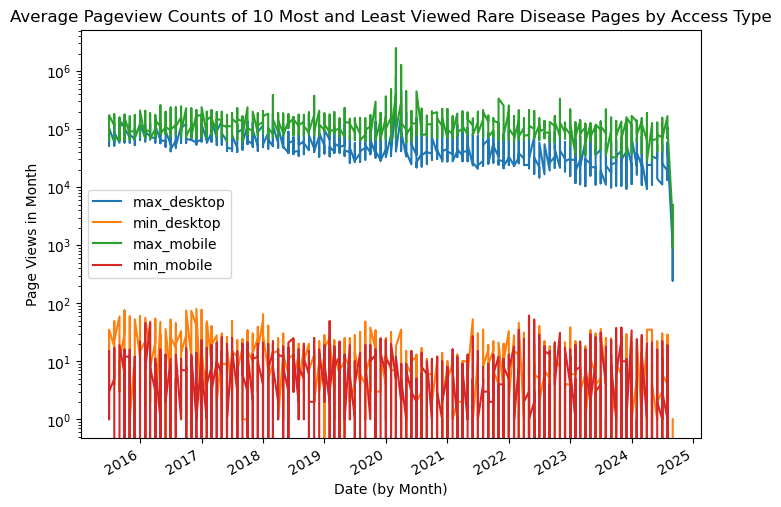

In [287]:
# Defining single axis object for all four plots
fig, ax = plt.subplots(figsize=(8,6))
# Removing the three articles with titles that cause errors in the Wikimedia Analytics API
pageview_desktop_df = pageview_desktop_df[pageview_desktop_df.timestamp != -1]
# Converting desktop timestamps to Datetime format for time series plotting
pageview_desktop_df.timestamp = pd.to_datetime(pageview_desktop_df.timestamp, format="%Y%m%d00")
# Plotting top and bottom 10 average pageviews over time for desktop users
pageview_desktop_df[pageview_desktop_df.article.isin(desktop_top_10)][['article','views','timestamp']].plot(x='timestamp', y='views', label="max_desktop", ax=ax, logy=True)
pageview_desktop_df[pageview_desktop_df.article.isin(desktop_bottom_10)][['article','views','timestamp']].plot(x='timestamp', y='views', label="min_desktop", ax=ax, logy=True)

# Once again removing the three articles with titles that cause errors in the Wikimedia Analytics API
pageview_mobile_df = pageview_mobile_df[pageview_mobile_df.timestamp != -1]
# Converting mobile timestamps to Datetime format for time series plotting
pageview_mobile_df.timestamp = pd.to_datetime(pageview_mobile_df.timestamp, format="%Y%m%d00")
# Plotting top and bottom 10 average pageviews over time for mobile users
pageview_mobile_df[pageview_mobile_df.article.isin(mobile_top_10)][['article','views','timestamp']].plot(x='timestamp', y='views', label="max_mobile", ax=ax, logy=True)
pageview_mobile_df[pageview_mobile_df.article.isin(mobile_bottom_10)][['article','views','timestamp']].plot(x='timestamp', y='views', label="min_mobile", ax=ax, logy=True)

# Adding title and labels to plot
plt.title("Average Pageview Counts of 10 Most and Least Viewed Rare Disease Pages by Access Type")
plt.xlabel('Date (by Month)')
plt.ylabel("Page Views in Month")
# Saving plot
plt.savefig("MostAndLeastViewedPagecounts.png")
plt.show()

From the above graph, it can be seen that the desktop pageview counts were higher than the mobile pageview counts for the 10 least viewed pages, suggesting marginally higher baseline viewership on desktop. For the top 10 pagecounts, the results are noticably higher for mobile users, with the effect being especially pronounced on the large spike during the height of the pandemic wherein mobile briefly sees a higher average pageview count in its top 10 rare diseases pages.

The second set of questions to be answered by this analysis is whether or not the pageview counts of the rare disease pages with the highest peak views differs consistently between desktop and mobile users.

To answer this question, both datasets will be filtered for the articles that have the top 10 peak pageview counts. This filtered dataset will then be grouped by article title and pageviews will be plotted against date for each article in both datasets.

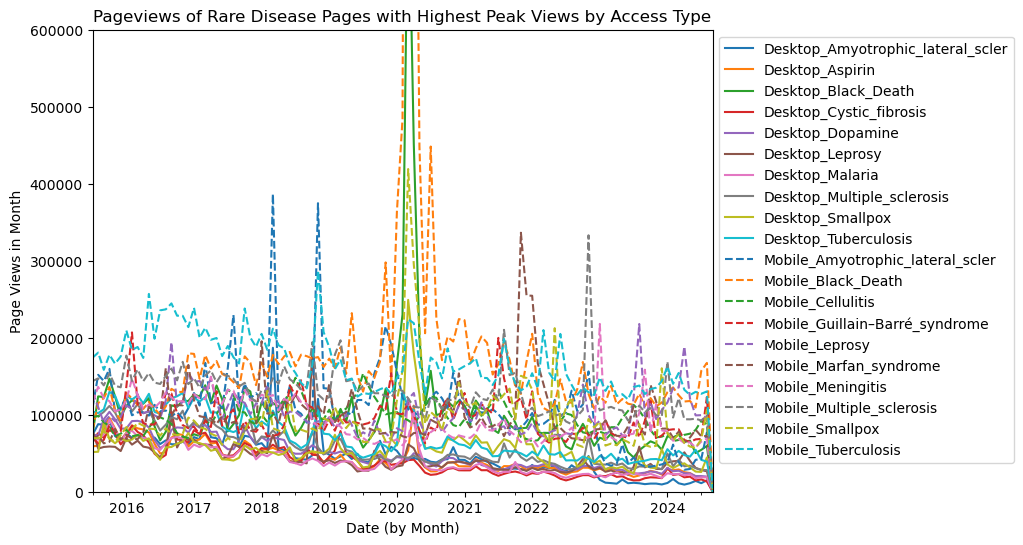

In [290]:
#pageview_desktop_df[pageview_desktop_df.article.isin(desktop_top_10)].groupby('article')

# Defining single axis for all twenty plots
fig, ax = plt.subplots(figsize=(8,6))
# plotting 10 highest peak pageview count destop rare disease pages
for label, df in pageview_desktop_df[pageview_desktop_df.article.isin(desktop_top_10)].groupby('article'):
    df.plot(x='timestamp', y='views', ax=ax, label="Desktop_" + label[:25], ylim=(0, 600000))
# plotting 10 highest peak pageview count mobile rare disease pages
for label, df in pageview_mobile_df[pageview_mobile_df.article.isin(mobile_top_10)].groupby('article'):
    df.plot(x='timestamp', y='views', ax=ax, label="Mobile_" + label[:25], style='--', ylim=(0, 600000))
# Moving legend out of plot for readability
ax.legend(bbox_to_anchor=(1.0, 1.0))
# Adding title and labels to plot
plt.title("Pageviews of Rare Disease Pages with Highest Peak Views by Access Type")
plt.xlabel('Date (by Month)')
plt.ylabel("Page Views in Month")
# Saving plot
plt.savefig("HighestPeakPagecounts.png")
plt.show()

From this graph, it can be seen that no consistently higher pageview counts can be clearly seen for either desktop or mobile users among the pages with the highest peak views. However, it _can_ be seen that sudden spikes in pageview counts are higher for mobile users than they are for desktop users.

The final question to be answered by this analysis is the question of whether or not the rare disease pages with the fewest months of data avilable high consistently higher pageview counts for either desktop or mobile users.

In order to answer this question, the rare disease pages with the fewest months of pageview data for both datasets (excluding the three errored articles whose NaN values disqualify them from consideration) will be obtained by grouping the dataset by article title and taking the count of the number of monthly data points within each article's group.

In [237]:
print("Rare disease pages with 10 fewest months of desktop pageview data.")
desktop_10_lowest_data_pages =  pageview_desktop_df.groupby('article').count().sort_values('timestamp').head(10)['timestamp'].index.to_list()
pageview_desktop_df.groupby('article').count().sort_values('timestamp').head(10)['timestamp']

Rare disease pages with 10 fewest months of desktop pageview data.


article
Retinal_vasculopathy_with_cerebral_leukoencephalopathy_and_systemic_manifestations    33
Filippi_Syndrome                                                                      33
COVID-19_vaccine_misinformation_and_hesitancy                                         37
Joseph_Vinetz                                                                         40
Bradley_Monk                                                                          40
CDKL5_deficiency_disorder                                                             40
Spongy_degeneration_of_the_central_nervous_system                                     41
Hemolytic_jaundice                                                                    41
Deaf_plus                                                                             41
Ellis–Van_Creveld_syndrome                                                            44
Name: timestamp, dtype: int64

In [238]:
print("Rare disease pages with 10 fewest months of mobile pageview data.")
mobile_10_lowest_data_pages =  pageview_mobile_df.groupby('article').count().sort_values('timestamp').head(10)['timestamp'].index.to_list()
pageview_mobile_df.groupby('article').count().sort_values('timestamp').head(10)['timestamp']

Rare disease pages with 10 fewest months of mobile pageview data.


article
Retinal_vasculopathy_with_cerebral_leukoencephalopathy_and_systemic_manifestations    33
Filippi_Syndrome                                                                      33
COVID-19_vaccine_misinformation_and_hesitancy                                         37
Joseph_Vinetz                                                                         40
Bradley_Monk                                                                          40
CDKL5_deficiency_disorder                                                             40
Spongy_degeneration_of_the_central_nervous_system                                     41
Hemolytic_jaundice                                                                    41
Deaf_plus                                                                             41
Ellis–Van_Creveld_syndrome                                                            44
Name: timestamp, dtype: int64

With the the 10 least documented articles from both datasets identified, they can be directly compared by filtering the datasets for the above articles, grouping by article title, and plotting each article's time series data for pageview counts by month. Mobile data will be distinguished with dashed line plots.

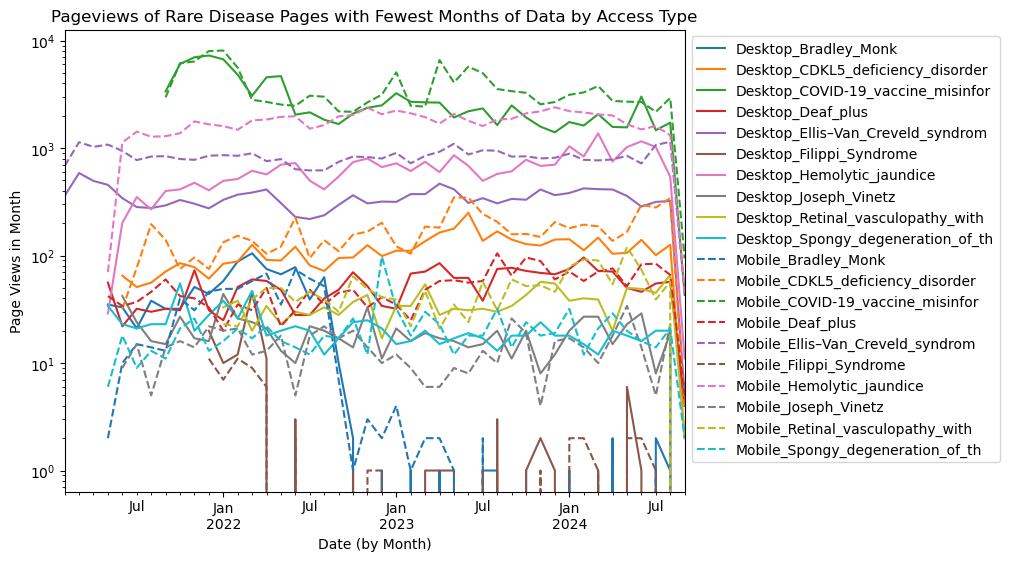

In [291]:
# Defining single axis for all twenty plots
fig, ax = plt.subplots(figsize=(8,6))
# plotting the 10 desktop rare disease pages with the fewest months of data
for label, df in pageview_desktop_df[pageview_desktop_df.article.isin(desktop_10_lowest_data_pages)].groupby('article'):
    df.plot(x='timestamp', y='views', ax=ax, label="Desktop_" + label[:25], logy=True)
# plotting the 10 mobile rare disease pages with the fewest months of data
for label, df in pageview_mobile_df[pageview_mobile_df.article.isin(mobile_10_lowest_data_pages)].groupby('article'):
    df.plot(x='timestamp', y='views', ax=ax, label="Mobile_" + label[:25], style='--', logy=True)
# Moving legend out of plot for readability
ax.legend(bbox_to_anchor=(1.0, 1.0))
# Adding title and labels to plot
plt.title("Pageviews of Rare Disease Pages with Fewest Months of Data by Access Type")
plt.ylabel("Page Views in Month")
plt.xlabel("Date (by Month)")
# Saving plot
plt.savefig("FewestMonthsOfDataPagecounts.png")
plt.show()

And by looking at the above plot, it can be seen that the pageview counts for low-data rare disease pages are consistently equal or higher for mobile users than for desktop users, showing a remarkably consistent trend.

Overall, this analysis has concluded that the overaching trend between these groups is that sudden spikes in pageview counts occur to a greater degree on mobile platforms than on desktop platforms.